<a href="https://colab.research.google.com/github/giuseppefiorentino67/moodle-xml_question_optimizer/blob/main/RingDetectionPapo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ring Detection in Sparse Matrix - Papo ver. 1.3
This script generates multiple rings in a 2D space, clusters points into rings,
and fits circles to the detected clusters.

##Imports
Used libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from sklearn.cluster import DBSCAN

##Debug
Ativate debugging with True

In [2]:
DEBUG = False

##Constants
Program-wide constants
###Space constants and constrains

In [3]:
#SCALE_FACTOR = 3000
X_MIN, X_MAX = 0.2, 0.8
Y_MIN, Y_MAX = 0.2, 0.8
R_MIN, R_MAX = 0.2, 0.8

# Sample points to hold
def is_a_good_point(p):
    return p[0] >= 0 and p[0] <= 1 and p[1] >=0 and p[1] <= 1

###Rings constants

In [4]:
#NUM_RINGS = 3
NUM_RINGS = np.random.randint(1, 3)
POINTS_PER_RING = 500
RADIUS_SCATTER = 0.01

print(f"NUM_RINGS = {NUM_RINGS}")

NUM_RINGS = 2


###Adaptive clustering constants and help functions

In [5]:
MIN_CLUSTERS = 5 - NUM_RINGS
MAX_CLUSTERS = 5 + NUM_RINGS

def set_min_max_clusters(num_rings):
    global MIN_CLUSTERS, MAX_CLUSTERS
    #MIN_CLUSTERS = 4 * num_rings
    #MAX_CLUSTERS = 6 * num_rings
    MIN_CLUSTERS = int(5 * num_rings - 1)
    MAX_CLUSTERS = int(7 * num_rings + 1)
    MIN_CLUSTERS = int(9 * num_rings - 1)
    MAX_CLUSTERS = int(9 * num_rings + 1)
    MIN_CLUSTERS = 4
    MAX_CLUSTERS = 6

set_min_max_clusters(NUM_RINGS)
print(f"MIN_CLUSTERS = {MIN_CLUSTERS}")
print(f"MAX_CLUSTERS = {MAX_CLUSTERS}")

MIN_CLUSTERS = 4
MAX_CLUSTERS = 6


###DBSCAN constants
Constants to fine-tune DBSCAN

In [6]:
DBSCAN_EPS = 0.1        # Initial DBSCAN eps
MIN_DBSCAN_EPS = 1e-6   # Minimum DBSCAN eps
MAX_DBSCAN_EPS = 1      # Maximum DBSCAN eps
MIN_SAMPLES = 6         # Minimum number of points per cluster
MAX_ITER = 40           # Maximum number of DBSCAN iterations

DBSCAN_ZOOM = 2         # Initial zoom factor (> 1)
DBSCAN_ZOOM_START = 0   # Initial zoom direction: None
DBSCAN_ZOOM_IN   =  1   # Zoom direction in
DBSCAN_ZOOM_OUT  = -1   # Zoom direction out

###Cluster circle bounds and help functions
Acceptable circle constrains for cluster fitting circles

In [7]:
CLUSTER_X_MIN, CLUSTER_X_MAX = -1.0, 2.0
CLUSTER_Y_MIN, CLUSTER_Y_MAX = -1.0, 2.0
CLUSTER_R_MIN, CLUSTER_R_MAX =  0.1, 2.0

#MAX_RADIUS_ERROR = R_MIN /10    # Maximum acceptable radius error
MAX_RADIUS_ERROR = 3 * RADIUS_SCATTER    # Maximum acceptable radius error
MAX_RMSE = 5 * RADIUS_SCATTER   # Maximum acceptable cluster RMSE

def is_a_good_circle_short(circle, errors, rmse):
    return circle[0] >= CLUSTER_X_MIN and circle[0] <= CLUSTER_X_MAX and \
           circle[1] >= CLUSTER_Y_MIN and circle[1] <= CLUSTER_Y_MAX and \
           circle[2] >= CLUSTER_R_MIN and circle[2] <= CLUSTER_R_MAX and \
           errors[2] <= MAX_RADIUS_ERROR and rmse <= MAX_RMSE # va rifinito

def is_a_good_circle(circle, errors, rmse):
    if circle[0] < CLUSTER_X_MIN or circle[0] > CLUSTER_X_MAX or \
       circle[1] < CLUSTER_Y_MIN or circle[1] > CLUSTER_Y_MAX:
        return False, f"INVALID - Bad center: ({circle[0]:.4f}, {circle[1]:.4f})"

    if circle[2] < CLUSTER_R_MIN or circle[2] > CLUSTER_R_MAX:
        return False, f"INVALID - Bad radius: {circle[2]:.4f}"

    if errors[2] > MAX_RADIUS_ERROR:
        return False, f"INVALID - Bad radius error: {errors[2]:.4f}"

    if rmse > MAX_RMSE:
        return False, f"INVALID - Bad RMSE: {rmse:.4f}"

    return True, "Valid circle"

###Singular matrix tolerance

In [8]:
MATRIX_SINGULAR_TOL = 1e-6

##Control randomness
Fix random state for reproducibility

In [9]:
START_SEED = -1

if START_SEED >= 0:
    np.random.seed(START_SEED)

##Handle plot styles and colors
Constants and functions to handle (graphic) outputs
###Create a colormap with unique colors

In [10]:
def mycolors(i):
    # Ottieni la colormap Set1
    cmap = plt.get_cmap("Set1")

    # Numero di colori nella colormap
    num_colors = cmap.N

    # Calcolo dell'indice ciclico
    cyclic_index = i % num_colors

    # Restituisce il colore corrispondente
    return cmap(cyclic_index)

def mycolors(i):
    # Restituisce il colore corrispondente
    return f"C{i}"

CURCOLOR = 0
def get_color(next_color=None):
    global CURCOLOR

    if next_color:
        CURCOLOR = next_color % 10

    color = f"C{CURCOLOR}"
    CURCOLOR = (CURCOLOR + 1) % 10

    return color

###Textual output

####Print circle

In [11]:
def print_circle(circle, errors=None, title=None, label=None):
    if title:
        print(title)

    if label:
        print(f"{label}: ", end='')

    if errors is not None:
        print(f"Center = ({circle[0]:.4f} ± {errors[0]:.4f}, "
                        f"{circle[1]:.4f} ± {errors[1]:.4f}), "
              f"Radius  = {circle[2]:.4f} ± {errors[2]:.4f}"
        )
    else:
        print(f"Center = ({circle[0]:.4f}, {circle[1]:.4f}), "
              f"Radius  = {circle[2]:.4f}"
        )

#======================= Example usage ========================================#
print_circle([1, 2, 3], [0.1, 0.2, 0.3], title="Circle", label="C")

Circle
C: Center = (1.0000 ± 0.1000, 2.0000 ± 0.2000), Radius  = 3.0000 ± 0.3000


###Print circles

In [12]:
def print_circles(circles, errors=None, title=None, label=None, enum=False):
    if title:
        print(title)

    for i, circle in enumerate(circles):
        err = errors[i] if errors else None
        lbl = f"{label}{f'{i}' if enum else ''}" if label else None
        print_circle(circle, err, label=lbl)

#======================= Example usage ========================================#
print_circles([[1, 2, 3], [4, 5, 6]], [[0.1, 0.2, 0.3], [0.4, 0.5, 0.6]],
              title="Circles", label="C", enum=True)

Circles
C0: Center = (1.0000 ± 0.1000, 2.0000 ± 0.2000), Radius  = 3.0000 ± 0.3000
C1: Center = (4.0000 ± 0.4000, 5.0000 ± 0.5000), Radius  = 6.0000 ± 0.6000


####Print points
Stampa i primi *limit* punti in un formato leggibile

In [13]:
def print_points(points, title=None, label=None, enum=False, limit=10):
    if title:
        print(title)

    for i, point in enumerate(points[:limit]):
        lbl = f"{label}{f'{i}' if enum else ''} :" if label else ""
        print(f"{lbl}({point[0]:.3f}, {point[1]:.3f})")

#======================= Example usage ========================================#
print_points([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]], title="Sample points",
             label='P', enum=True)

Sample points
P0 :(1.000, 2.000)
P1 :(3.000, 4.000)
P2 :(5.000, 6.000)
P3 :(7.000, 8.000)
P4 :(9.000, 10.000)


###Graphical outputs
Functions and constants to handle plots

In [14]:
PLOT_BOUND = True
PLOT_X_MIN = 0
PLOT_X_MAX = 1
PLOT_Y_MIN = 0
PLOT_Y_MAX = 1

LINEWIDTH = 2
POINTSIZE = 10

#### Common plot code

In [15]:
def plot_commons(plt, title=None, legend=False,
                 grid=True, bound=PLOT_BOUND, plot=True):

    plt.gca().set_aspect("equal")  # Ensure the plot is square
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(grid)

    if bound:
        plt.xlim(PLOT_X_MIN, PLOT_X_MAX)
        plt.ylim(PLOT_Y_MIN, PLOT_Y_MAX)

    if title:
        plt.title(title)

    if legend:
        plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left",
                   ncol=2, borderaxespad=0)

    if plot:
        plt.show()

#### Plot circle

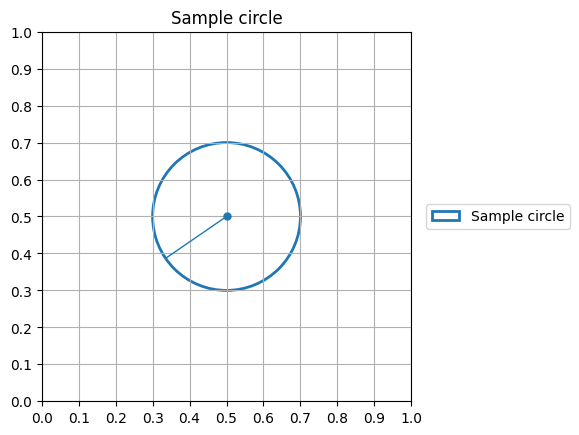

In [16]:
def plot_circle(circle, title=None, label=None, legend=False,
                color=None, fill=False, linewidth=LINEWIDTH, grid=True,
                radius=True, center=True, bound=PLOT_BOUND, plot=True):

    # Pick color
    this_color = color if color else get_color()

    # unpack circle data
    xc, yc, r = circle

    # Plot center and (random) radius
    if center:
        if radius:
            theta = np.random.uniform(0, 2 * np.pi)
            xc1 = xc + r * np.cos(theta)
            yc1 = yc + r * np.sin(theta)
            plt.plot([xc, xc1], [yc, yc1], color=this_color, linewidth=1)

        plt.plot(xc, yc, 'o', color=this_color, markersize=5)

    # Plot circle
    this_circle = plt.Circle((xc, yc), r, color=this_color, fill=fill,
                             linewidth=linewidth, label=label)
    plt.gca().add_artist(this_circle)

    plot_commons(plt, title=title, legend=legend, grid=grid, bound=bound, plot=plot)

#======================= Example usage ========================================#
plot_circle([0.5, 0.5, 0.2], title="Sample circle", label="Sample circle", legend=True)

#### Plot circles

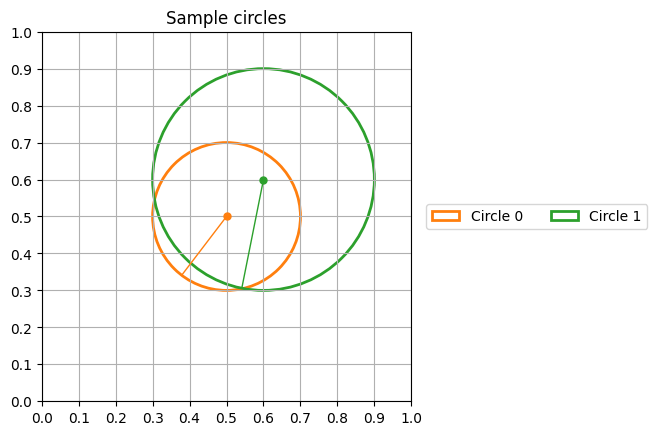

In [17]:
def plot_circles(circles, title=None, color=None, fill=False, linewidth=2,
                 label='', enum=False, legend=False,
                 grid=True, centers=True, bound=PLOT_BOUND, plot=True):

    # Plot all circles
    for i, circle in enumerate(circles):

        # Pick a color
        this_color = color if color else get_color()

        # Prepare label
        lbl = f"{label}{f'{i}' if enum else ''}" if label else None

        # Plot single circle
        plot_circle(circle=circle, title=None, color=this_color, fill=fill,
                    linewidth=linewidth, grid=False,
                    label=lbl, legend=False, center=centers,
                    bound=bound, plot=False)

    plot_commons(plt, title=title, legend=legend, grid=grid, bound=bound, plot=plot)

#======================= Example usage ========================================#
plot_circles([[0.5, 0.5, 0.2], [0.6, 0.6, 0.3]], title="Sample circles",
             label='Circle ', enum=True, legend=True)

#### Plot points

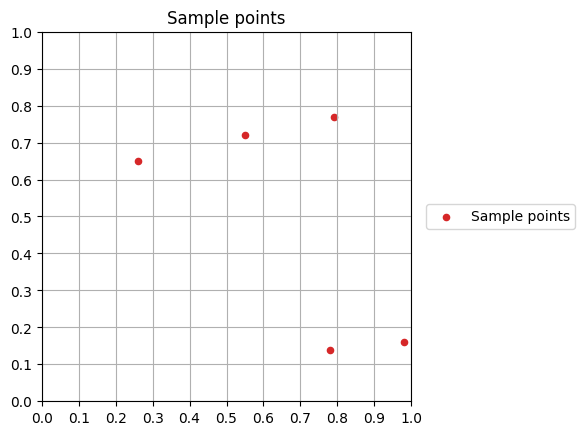

In [18]:
def plot_points(points, title=None, color=None, pointsize=POINTSIZE,
                label=None, legend=False,
                grid=True, bound=True, plot=True):

    # Pick color
    this_color = color if color else get_color()

    # Unpack the points into x and y coordinates
    x_coords, y_coords = zip(*points)

    # Plot the points
    plt.scatter(x_coords, y_coords, s=pointsize, color=this_color, label=label)

    plot_commons(plt, title=title, legend=legend, grid=grid, bound=bound, plot=plot)

#======================= Example usage ========================================#
points = [[0.55, 0.72], [0.98, 0.16], [0.26, 0.65], [0.79, 0.77], [0.78, 0.14]]
plot_points(points, pointsize=20, title="Sample points", label='Sample points', legend=True)

## Program start

### Step 1: Generate random circles

Initial circles
Circle 0: Center = (0.5714, 0.2340), Radius  = 0.5877
Circle 1: Center = (0.3530, 0.5716), Radius  = 0.3586


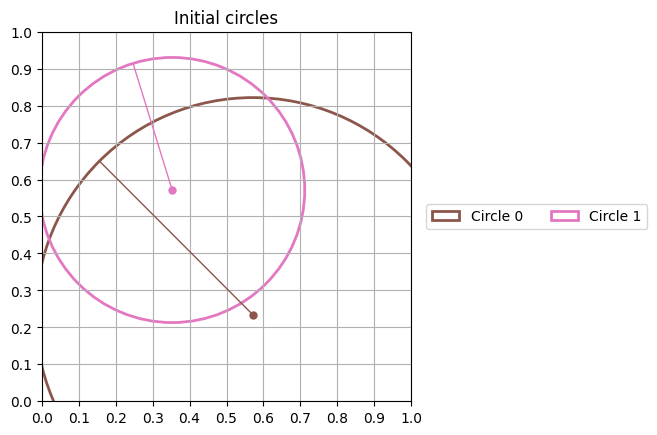

In [19]:
def generate_circles(num_circles,
                     x_min=X_MIN, x_max=X_MAX, y_min=Y_MIN, y_max=Y_MAX,
                     r_min=R_MIN, r_max=R_MAX):
    """
    Generates an array of num_circles circles of the form [x, y, r].

    Args:
    - num_circles (int): Number of circles to generate.
    - x_min (float): Minimum value for x.
    - x_max (float): Maximum value for x.
    - y_min (float): Minimum value for y.
    - y_max (float): Maximum value for y.
    - r_min (float): Minimum value for r.
    - r_max (float): Maximum value for r.

    Returns:
    - Array of generated circles.
    """
    circle_list = []

    for _ in range(num_circles):
        x = np.random.uniform(x_min, x_max)
        y = np.random.uniform(y_min, y_max)
        r = np.random.uniform(r_min, r_max)
        circle_list.append([x, y, r])

    return circle_list

#======================= Example usage ========================================#
# Reset random seed
if START_SEED >= 0:
    np.random.seed(START_SEED)

# Generate sample circles
initial_circles = generate_circles(NUM_RINGS)

# Show generated circles
get_color(0)
print_circles(initial_circles, title="Initial circles", label='Circle ', enum=True)
plot_circles(initial_circles, title="Initial circles", label='Circle ', enum=True, legend=True)

### Step 2: Generate ring data
Generate random ring data along the given circles

#### Generate ring
Generates a single ring of points of the form [x, y] in a numpy array.

In [20]:
def generate_ring(circle, points_per_ring=POINTS_PER_RING,
                  radius_scatter=RADIUS_SCATTER, filter_func=is_a_good_point):
    """
    Generates a single ring and concatenates the points in a single numpy array.

    Parameters:
        circles (np.ndarray): A numpy array of circles, where each circle is represented as [x, y, r].
        points_per_ring (int): Number of points to generate for each ring.
        radius_scatter (float): Allowed variation in the radius (R ± radius_scatter).
        filter_func (callable, optional): A function to filter points. Should accept a point [x, y] and return True if the point is valid.

    Returns:
        A list of [x, y] coordinates representing all generated points for the ring.
    """
    center_x, center_y, ring_radius = circle

    angles = np.random.uniform(0, 2 * np.pi, points_per_ring)
    radii = ring_radius + np.random.uniform(-radius_scatter, radius_scatter, points_per_ring)

    x_coords = center_x + radii * np.cos(angles)
    y_coords = center_y + radii * np.sin(angles)

    points = zip(x_coords, y_coords)

    # Filter points if a filter function is provided
    if filter_func:
        return list(filter(filter_func, points))
    else:
        return list(points)

#### Generate rings
Generates multiple rings and concatenates the points in a single numpy array.

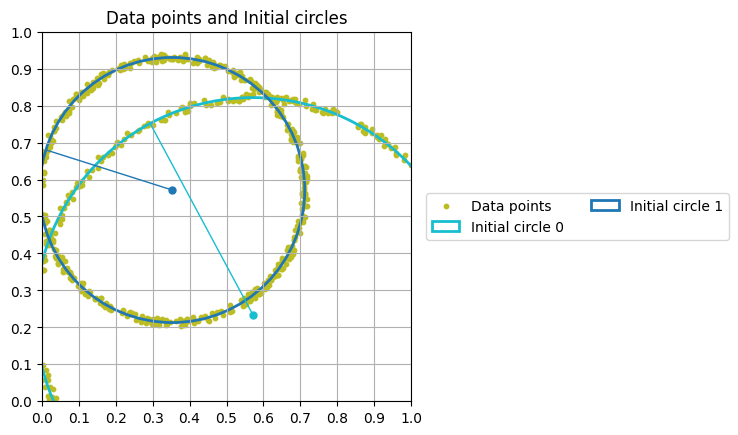

In [21]:
def generate_rings(circles, points_per_ring=POINTS_PER_RING, radius_scatter=RADIUS_SCATTER, filter_func=is_a_good_point):
    """
    Generates multiple rings and concatenates the points in a single numpy array.

    Parameters:
        circles (np.ndarray): A numpy array of circles, where each circle is represented as [x, y, r].
        points_per_ring (int): Number of points to generate for each ring.
        radius_scatter (float): Allowed variation in the radius (R ± radius_scatter).
        filter_func (callable, optional): A function to filter points. Should accept a point (x, y) and return True if the point is valid.

    Returns:
        np.ndarray: A numpy array of (x, y) coordinates representing all generated points for the rings.
    """

    # Inizializza una lista vuota per memorizzare i punti di tutti gli anelli.
    all_points = []

    # Itera sui cerchi e genera i punti per ogni anello usando 'generate_ring'.
    for circle in circles:
        points = generate_ring(circle, points_per_ring, radius_scatter, filter_func)
        all_points.extend(points)  # Aggiungi i punti alla lista.

    # Converti la lista di punti in un np.array.
    return np.array(all_points)

#======================= Example usage ========================================#
data_points = generate_rings(initial_circles)
#print_points(data_points, "10 generated points", 10)

# Grafico dei punti e dei cerchi
get_color(0)
plot_points(data_points, title="Data points and Initial circles", label="Data points", plot=False)
plot_circles(initial_circles, label="Initial circle ", enum=True, legend=True)

## Step 3: Cluster Data points
Cluster data points adjusting the eps parameter of DBSCAN until the number of clusters is within the desired range.

Target number of clusters: 4 to 6
Iteration 1: current_eps = 0.1000, clusters =  2, dir =  0, zoom = 2.0000
Iteration 2: current_eps = 0.0500, clusters =  3, dir = -1, zoom = 2.0000
Iteration 3: current_eps = 0.0250, clusters = 14, dir = -1, zoom = 2.0000
Iteration 4: current_eps = 0.0375, clusters =  3, dir =  1, zoom = 1.5000
Iteration 5: current_eps = 0.0313, clusters =  6, dir = -1, zoom = 1.2000
Final DBSCAN eps: 0.0313

Found 6 clusters and 6 unclustered points


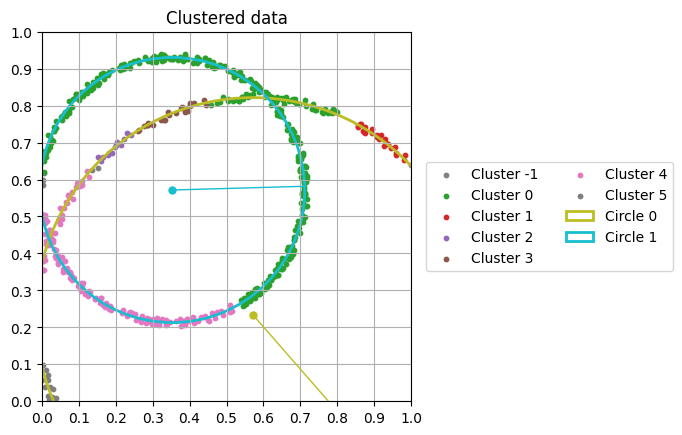

In [22]:
def adaptive_clustering(points,
                        min_clusters=MIN_CLUSTERS, max_clusters=MAX_CLUSTERS,
                        initial_eps=DBSCAN_EPS, min_samples=MIN_SAMPLES,
                        max_iter=MAX_ITER, initial_zoom=DBSCAN_ZOOM):
    """
    Adjusts the eps parameter for DBSCAN until the number of clusters is within the desired range.

    Parameters:
        points (np.ndarray): The points to cluster.
        min_clusters (int): Minimum acceptable number of clusters.
        max_clusters (int): Maximum acceptable number of clusters.
        initial_eps (float): Starting value for eps.
        min_samples (int): DBSCAN min_samples parameter.
        max_iter (int): Maximum number of iterations.

    Returns:
        tuple: (labels, final_eps)
            - labels: Cluster labels for each point.
            - final_eps: The eps value used for the final clustering.
    """
    # Handle zoom value and direction
    zoom = initial_zoom
    zoom_dir = DBSCAN_ZOOM_START

    current_eps = initial_eps
    for iteration in range(max_iter):
        clustering = DBSCAN(eps=current_eps, min_samples=min_samples).fit(points)
        labels = clustering.labels_

        # Count clusters
        cluster_count = len([label for label in set(labels) if label != -1])
        print(f"Iteration {iteration+1}: current_eps = {current_eps:.4f}, "
              f"clusters = {cluster_count:2d}, dir = {zoom_dir:2d}, zoom = {zoom:.4f}")

        if cluster_count < min_clusters:
            # Too few clusters -> decrease current_eps to split clusters.

            # Adjust zoom factor according to previous direction
            if zoom_dir == DBSCAN_ZOOM_IN:
                zoom = 2 * zoom / (zoom + 1)

            # Zoom in and remember last zoom direction
            current_eps /= zoom
            zoom_dir = DBSCAN_ZOOM_OUT

        elif cluster_count > max_clusters:
            # Too many clusters -> increase current_eps to merge clusters.

            # Adjust zoom factor according to previous direction
            if zoom_dir == DBSCAN_ZOOM_OUT:
                zoom = (zoom + 1) / 2

            # Zoom out and remember last zoom direction
            current_eps *= zoom
            zoom_dir = DBSCAN_ZOOM_IN

        else:
            # Clusters within the desired range, break out.
            break

        if current_eps < MIN_DBSCAN_EPS or current_eps > MAX_DBSCAN_EPS:
            print("DBSCAN eps out of range")
            break

    #return list(label_set), labels, len(cluster_list) != len(label_set), current_eps
    return labels, current_eps

#======================= Example usage ========================================#
print(f"Target number of clusters: {MIN_CLUSTERS} to {MAX_CLUSTERS}")
cluster_labels, final_dbscan_eps = adaptive_clustering(data_points)
print(f"Final DBSCAN eps: {final_dbscan_eps:.4f}\n")

# Get all unique labels
unique_labels = np.unique(cluster_labels)

# Are there unclustered points?
unclustered = -1 in unique_labels
unclustered_size = np.count_nonzero(cluster_labels == -1) if unclustered else 0

# Get number or real clusters
num_clusters = len(unique_labels)
num_clusters -= 1 if unclustered else 0  # Escludi -1 se presente
print(f"Found {num_clusters} clusters and "
      f"{unclustered_size if unclustered else 0} unclustered points")

# Build cluster dictionary
cluster_dict = {}

for label in unique_labels:
    cluster_points = data_points[cluster_labels == label]

    cluster_dict[label] = {
        'points': cluster_points,
        'size': len(cluster_points),
        'circle': None,
        'errors': None,
        'rmse': None,
        'valid': None
    }

# Get cluster cardinality (also for the cluster -1)
#cluster_card = {}
#for label in unique_labels:
#    cluster_card[label] = np.count_nonzero(cluster_labels == label)

# Print clusters data
if DEBUG:
    for label, info in cluster_dict.items():
        print(f"Cluster {label:2d}: {info['size']:4d} points")


get_color(0)
for label in unique_labels:
    color = 'gray' if label == -1 else get_color()
    plot_points(cluster_dict[label]['points'], color=color,
                label=f"Cluster {label}", plot=False)

plot_circles(circles=initial_circles, title='Clustered data',
             label='Circle ', enum=True, legend=True)

## Fit circle to points

Fitted circle
Center = (0.3815 ± 0.0040, 0.5459 ± 0.0041), Radius  = 0.3638 ± 0.0029


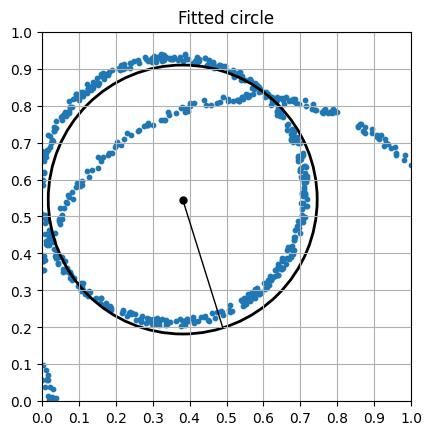

In [23]:
def fit_circle_to_points(points, singular_tol=MATRIX_SINGULAR_TOL, DEBUG=DEBUG):
    """
    Fit a circle to a set of points using the Levenberg-Marquardt algorithm.
    """
    def residuals(params):
        xc, yc, r = params
        radii = np.sqrt((points[:, 0] - xc) ** 2 + (points[:, 1] - yc) ** 2)
        return radii - r

    num_points = len(points)
    if num_points < MIN_SAMPLES:
        print(f"FIT - Not enough points to fit a circle: {num_points}")
        return None

    center_guess  = np.mean(points, axis=0)
    radius_guess  = np.mean(np.sqrt(np.sum((points - center_guess)**2, axis=1)))
    initial_guess = np.append(center_guess, radius_guess)

    result = least_squares(residuals, initial_guess)

    # Return None if fails to converge
    if result.status <= 0:
        print(f"FIT - Fit failed: {result.status}")
        return None
    elif DEBUG:
        print(f"Fit status: {result.status}, cost: {result.cost}")

    # Ottieni i residui
    residuals = result.fun

    # Calcola la RSS
    rss = np.sum(residuals ** 2)

    # Calcola i gradi di libertà
    df = len(points) - len(initial_guess)

    # Calcola l'RMSE
    rmse = np.sqrt(rss / df)

    # Compute estimated error
    Jac = result.jac    # Jacobiana
    MIO = Jac.T @ Jac   # Matrice di Informazione Osservata
    det = np.linalg.det(MIO)

    if DEBUG:
        print(f"det(MIO) = {det}")

    # Check for (almost) singular matrix
    if abs(det) < singular_tol:
        print("FIT - (Almost) singular matrix detected")
        return None

    # Extimate errors
    covariance_matrix = np.linalg.inv(MIO) * rss / df
    param_errors = np.sqrt(np.diag(covariance_matrix))

    if DEBUG:
        print(f"FIT - Covariance_matrix =\n{np.diag(covariance_matrix)}")
        print(f"FIT - Points: {len(points)}, Cost: {result.cost:.4f}, RMSE: {rmse:.4f}")

    # Return fitted data
    return result.x, param_errors, rmse

#======================= Example usage ========================================#
fitted_circle, fitting_errors, rmse = fit_circle_to_points(data_points)

print_circle(fitted_circle, fitting_errors, title="Fitted circle")
plot_points(data_points, plot=False)
plot_circle(fitted_circle, title="Fitted circle", color='black')

## Fit circles to clusters

In [24]:
def uncluster_points(labels):
    global cluster_labels
    for cluster in set(labels):
        if cluster == -1:
            continue
        cluster_labels[cluster_labels == label] = -1

Cluster  0: 395 points,	Center = (0.3614 ± 0.0025, 0.5737 ± 0.0026), Radius  = 0.3582 ± 0.0021
Cluster  1:  24 points,	Center = (0.6495 ± 0.1539, 0.3360 ± 0.2137), Radius  = 0.4597 ± 0.2616
Cluster  2:  13 points,	Center = (-0.1101 ± 0.4049, 1.0334 ± 0.4564), Radius  = 0.4644 ± 0.6080
Cluster  3:  29 points,	Center = (0.9768 ± 0.7498, -0.6841 ± 1.7305), Radius  = 1.5883 ± 1.8844
Cluster  4: 172 points,	Center = (0.3134 ± 0.0045, 0.4828 ± 0.0055), Radius  = 0.2766 ± 0.0051
Cluster  5:  15 points,	Center = (0.4801 ± 1.0090, 0.1655 ± 0.2629), Radius  = 0.4786 ± 1.0402


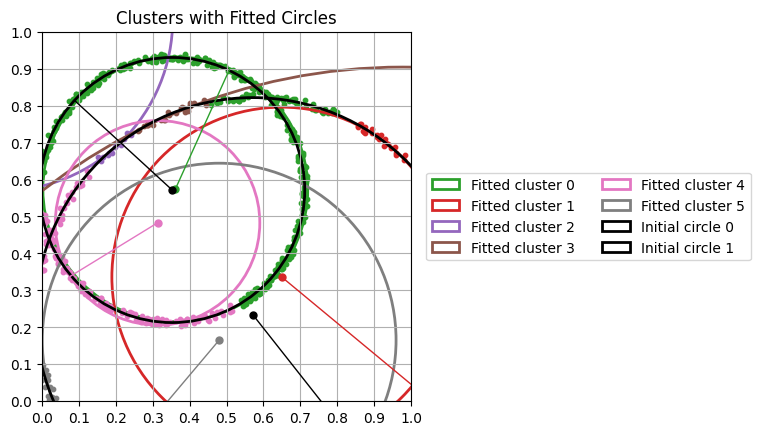

In [25]:
def fit_circles_to_clusters(cluster_labels):
    # initialize lists to output data
    #global fitted_circles, fitted_errors, fitted_rmses, cluster_dict
    global cluster_dict

    #fitted_circles = []
    #fitted_errors = []
    #fitted_rmses = []

    fitted_labels = []
    unfitted_labels = []

    for label in set(cluster_labels):

        if label == -1:
            continue  # Skip unclustered points

        # Get cluster points
        #cluster_points = np.array(data_points[np.where(cluster_labels == label)])
        cluster_points = cluster_dict[label]['points']
        #assert np.array_equal(cluster_points, cluster_points1)

        #cluster_size = len(cluster_points)
        cluster_size = cluster_dict[label]['size']
        #assert cluster_size == cluster_size1

        # Fit circle to the cluster
        #print(f"Fitting circle to cluster {label} ({cluster_size} points)")
        fit_results = fit_circle_to_points(cluster_points)

        # Continue if no fit
        if not fit_results:
            print(f"Skipping cluster {label}")
            unfitted_labels.append(label)
            continue

        # Unpack the result
        fitted_circle, fitted_error, fitted_rmse = fit_results

        # Update dictionary
        cluster_dict[label]['circle'] = fitted_circle
        cluster_dict[label]['errors'] = fitted_error
        cluster_dict[label]['rmse'] = fitted_rmse

        # Add data
        #fitted_circles.append(fitted_circle)
        #fitted_errors.append(fitted_error)
        #fitted_rmses.append(fitted_rmse)
        fitted_labels.append(label)

    #fitted_circles = np.array(fitted_circles)
    #fitted_errors = np.array(fitted_errors)
    #fitted_rmses = np.array(fitted_rmses)
    #fitted_labels = np.array(fitted_labels)

    #return fitted_circles, fitted_errors, fitted_rmses, fitted_labels
    return fitted_labels, unfitted_labels

#======================= Example usage ========================================#
#fitted_circles, fitted_errors, fitted_rmses, fitted_labels = fit_circles_to_clusters(cluster_labels, data_points)
#fit_circles_to_clusters(cluster_labels)
fitted_labels, unfitted_labels = fit_circles_to_clusters(cluster_labels)

if unfitted_labels:
    print(f"Unfitted clusters: {unfitted_labels}\n")

get_color(0)
#for circle, error, rmse, label in zip(fitted_circles, fitted_errors, fitted_rmses, fitted_labels):
for label in fitted_labels:

    #cluster_points = data_points[np.where(cluster_labels == label)]
    cluster_points = cluster_dict[label]['points']
    #assert np.array_equal(cluster_points, cluster_points1)

    #num_points = len(cluster_points)
    num_points = cluster_dict[label]['size']
    #assert num_points == num_points1
    #print(f"Cluster {label}: {num_points} points")

    print(f"Cluster {label:2d}: {num_points:3d} points,", end='\t')
    circle = cluster_dict[label]['circle']
    error = cluster_dict[label]['errors']
    #rmse = cluster_dict[label]['rmse']

    print_circle(circle, error)
    #print('\t', is_a_good_circle(circle, error, rmse)[1])

    #cluster_dict[label]['circle'] = circle
    #cluster_dict[label]['errors'] = error
    #cluster_dict[label]['rmse'] = rmse

    # Plot cluster points
    color = get_color()
    plot_points(cluster_points, '', color=color, bound=True, plot=False)
    plot_circle(circle, label=f"Fitted cluster {label}",
                color=color, plot=False)

plot_circles(initial_circles, title="Clusters with Fitted Circles", label="Initial circle ", enum=True, color='black', legend=True)

In [26]:
def find_nearest_circle(initial_circles, circle):
    """
    Finds the nearest circle in initial_circles to the given circle.

    Args:
        initial_circles: A list of circles, where each circle is represented as a list [xc, yc, r].
        circle: The circle to find the nearest neighbor for, in the same format [xc, yc, r].

    Returns:
        The nearest circle in initial_circles.
    """

    # Convert lists to NumPy arrays for vectorized operations
    initial_circles_np = np.array(initial_circles)
    circle_np = np.array(circle)

    # Calculate Euclidean distances between the given circle and all circles in initial_circles
    distances = np.linalg.norm(initial_circles_np - circle_np, axis=1)

    # Find the index of the minimum distance
    nearest_circle_index = np.argmin(distances)

    return initial_circles[nearest_circle_index], nearest_circle_index

#======================= Example usage ========================================#
for label, circle_dict in cluster_dict.items():
    points = circle_dict['points']
    circle = circle_dict['circle']
    errors = circle_dict['errors']
    valid  = circle_dict['valid']

    if label == -1 or not valid:
        #print(f"Circle {label} is ivalid. Skipping refinement.")
        continue

    print_circle(circle, errors, label=f"\nCluster {label}")
    circle, index = find_nearest_circle(initial_circles, circle)
    print_circle(circle, errors=[0, 0, 0], label=f"Circle  {index}")

## Filter fitted circles

Circle  0: Center = (0.3614 ± 0.0025, 0.5737 ± 0.0026), Radius  = 0.3582 ± 0.0021
Cluster 0: RMSE = 0.0279, Valid circle
Circle  1: Center = (0.6495 ± 0.1539, 0.3360 ± 0.2137), Radius  = 0.4597 ± 0.2616
Cluster 1: RMSE = 0.0063, INVALID - Bad radius error: 0.2616
Circle  2: Center = (-0.1101 ± 0.4049, 1.0334 ± 0.4564), Radius  = 0.4644 ± 0.6080
Cluster 2: RMSE = 0.0059, INVALID - Bad radius error: 0.6080
Circle  3: Center = (0.9768 ± 0.7498, -0.6841 ± 1.7305), Radius  = 1.5883 ± 1.8844
Cluster 3: RMSE = 0.0058, INVALID - Bad radius error: 1.8844
Circle  4: Center = (0.3134 ± 0.0045, 0.4828 ± 0.0055), Radius  = 0.2766 ± 0.0051
Cluster 4: RMSE = 0.0207, Valid circle
Circle  5: Center = (0.4801 ± 1.0090, 0.1655 ± 0.2629), Radius  = 0.4786 ± 1.0402
Cluster 5: RMSE = 0.0072, INVALID - Bad radius error: 1.0402


Good clusters: [0, 4]
Bad  clusters: [1, 2, 3, 5]

Cluster/Circle 0 ( 395 points): Center = (0.3614 ± 0.0025, 0.5737 ± 0.0026), Radius  = 0.3582 ± 0.0021
		Nearest circle: Center = (

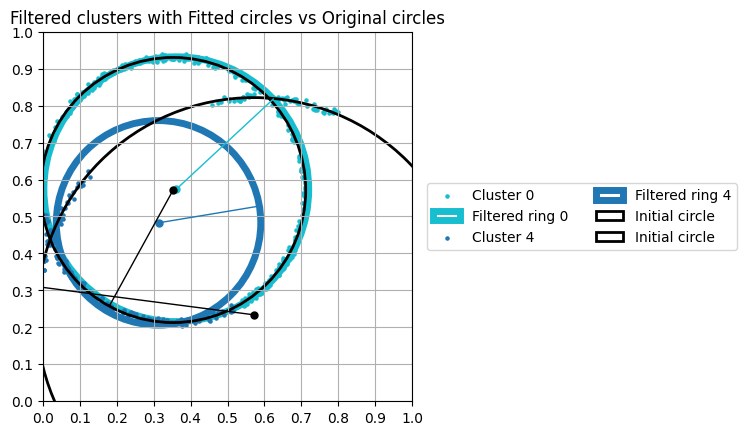

In [27]:
def filter_fitted_circles(fitted_labels):
    global cluster_dict

    # Set outputs
    good_clusters = []
    bad_clusters  = []

    #for circle, errors, rmse, label in zip(fitted_circles, fitted_errors, fitted_rmses, fitted_labels):
    for label in fitted_labels:
        circle = cluster_dict[label]['circle']
        errors = cluster_dict[label]['errors']
        rmse = cluster_dict[label]['rmse']

        circle_ok, reason = is_a_good_circle(circle, errors, rmse)
        cluster_dict[label]['valid'] = circle_ok

        print_circle(circle, errors=errors, label=f"Circle  {label}")
        print(f"Cluster {label}: RMSE = {rmse:.4f}, {reason}")

        if circle_ok:
            good_clusters.append(label)
        else:
            bad_clusters.append(label)

    return good_clusters, bad_clusters

#======================= Example usage ========================================#
filtered_labels, bad_clusters = filter_fitted_circles(fitted_labels)

print('\n')
print(f"Good clusters: {filtered_labels}")
print(f"Bad  clusters: {bad_clusters}\n")

get_color(0)

#for circle, errors, rmse, label in zip(filtered_circles, filtered_errors, filtered_rmses, filtered_labels):
for label in filtered_labels:
    circle = cluster_dict[label]['circle']
    errors = cluster_dict[label]['errors']
    #rmse = cluster_dict[label]['rmse']

    color=get_color()
    cluster_points = data_points[np.where(cluster_labels == label)]
    cluster_points1 = cluster_dict[label]['points']
    assert np.array_equal(cluster_points, cluster_points1)
    num_points = len(cluster_points)
    num_points1 = cluster_dict[label]['size']
    assert num_points == num_points1

    plot_points(cluster_points, '', color=color, pointsize=5, label=f"Cluster {label}", bound=True, plot=False)
    plot_circle(circle, label=f"Filtered ring {label}", linewidth=5, color=color, plot=False)
    print_circle(circle, errors=errors, label=f"Cluster/Circle {label} ({num_points:4d} points)")
    nearest_circle, _ = find_nearest_circle(initial_circles, circle)
    print_circle(nearest_circle, errors=[0, 0, 0], label=f"\t\tNearest circle")

plot_circles(initial_circles, label="Initial circle", color='black', legend=True, plot=False)
plt.title("Filtered clusters with Fitted circles vs Original circles")
plt.show()

## Compare and merge circles

In [28]:
def compatible_circles(circle_1, circle_2, error_1, error_2):
    """
    Check if two circles are compatible based on their 3D distance.
    """
    if DEBUG:
        print_circle(circle_1, error_1, label="Circle 1")
        print_circle(circle_2, error_2, label="Circle 2")
        print(f"Distance: {np.linalg.norm(circle_1 - circle_2)}")
        print(f"Error: {np.linalg.norm(error_1 + error_2)}")

    return np.linalg.norm(circle_1 - circle_2) < 3 * np.linalg.norm(error_1 + error_2)

#======================= Example usage ========================================#
for i in range(len(filtered_labels)):
    for j in range(i+1, len(filtered_labels)):
        circle_i = cluster_dict[filtered_labels[i]]['circle']
        circle_j = cluster_dict[filtered_labels[j]]['circle']
        error_i  = cluster_dict[filtered_labels[i]]['errors']
        error_j  = cluster_dict[filtered_labels[j]]['errors']
        if compatible_circles(circle_i, circle_j, error_i, error_j):
            print(f"Clusters/Circles {filtered_labels[i]} and {filtered_labels[j]} are compatible")

In [34]:
def compare_circles(labels):
    """
    Compares circles based on their centers and radii (within 3 sigma).
    If circles are compatible, they are merged into a single circle using weighted averages.

    Parameters:
        circles (list of np.ndarray): List of circle centers.
        errors (list of float): List of errors for the centers.
        labels (list of float): List of errors for the radii.

    Returns:
        tuple: (merged_centers, merged_radii, merged_center_errors, merged_radius_errors)
            - merged_centers: List of merged centers.
            - merged_radii: List of merged radii.
            - merged_center_errors: List of errors for the merged centers.
            - merged_radius_errors: List of errors for the merged radii.
    """
    global cluster_dict

    # Number of elements to merge
    num_elems = len(labels)

    # Initialize lists to store merged results
    merged_labels = []

    # Track the indices in each cluster
    compatibles = []
    merged = set()

    # Iterate through all circles
    for i in range(num_elems):
        label_i = labels[i]

        # Skip if this circle has already been merged
        if label_i in merged:
            #print(f"Cluster {label_i} already merged")
            continue

        # Start merging with the current circle
        circle_i = cluster_dict[label_i]['circle']
        error_i  = cluster_dict[label_i]['errors']
        print_circle(circle_i, error_i,
                     title=f"Checking cluster {label_i}", label=f"  Circle {label_i}")

        compatibles = [label_i]
        merged.add(label_i)

        # Scan other circles
        for j in range(i+1, num_elems):
            label_j = labels[j]

            # Skip if this circle has already been merged
            if label_j in merged:
                #print(f"Label {label_j} already merged")
                continue  # Skip if this circle has already been merged

            # Check compatibility
            circle_j = cluster_dict[label_j]['circle']
            error_j  = cluster_dict[label_j]['errors']
            if compatible_circles(circle_i, circle_j, error_i,  error_j):
                print_circle(circle_j, error_j,
                             title=f"  Cluster {label_j} added to cluster {label_i}", label=f"  Circle {label_j}")

                compatibles.append(label_j)
                merged.add(label_j)

        # Check for isolated cluster
        if len(compatibles) == 1:
            print(f"  Cluster {label_i} is isolated")
        print()

        # Add clustered circles to the merged_clusters list
        merged_labels.append(compatibles)

    return merged_labels

#======================= Example usage ========================================#
merged_labels = compare_circles(filtered_labels)

print("Merged labels:")
print(merged_labels)

Checking cluster 0
  Circle 0: Center = (0.3614 ± 0.0025, 0.5737 ± 0.0026), Radius  = 0.3582 ± 0.0021
  Cluster 0 is isolated

Checking cluster 4
  Circle 4: Center = (0.3134 ± 0.0045, 0.4828 ± 0.0055), Radius  = 0.2766 ± 0.0051
  Cluster 4 is isolated

Merged labels:
[[0], [4]]


Merging circles [0]
  Original circle 0: Center = (0.3614 ± 0.0025, 0.5737 ± 0.0026), Radius  = 0.3582 ± 0.0021
      Merged circle: Center = (0.3614 ± 0.0025, 0.5737 ± 0.0026), Radius  = 0.3582 ± 0.0021
      Compatibility: True

Merging circles [4]
  Original circle 0: Center = (0.3134 ± 0.0045, 0.4828 ± 0.0055), Radius  = 0.2766 ± 0.0051
      Merged circle: Center = (0.3134 ± 0.0045, 0.4828 ± 0.0055), Radius  = 0.2766 ± 0.0051
      Compatibility: True

Merged circles:
Merged 0: Center = (0.3614 ± 0.0025, 0.5737 ± 0.0026), Radius  = 0.3582 ± 0.0021
Merged 1: Center = (0.3134 ± 0.0045, 0.4828 ± 0.0055), Radius  = 0.2766 ± 0.0051


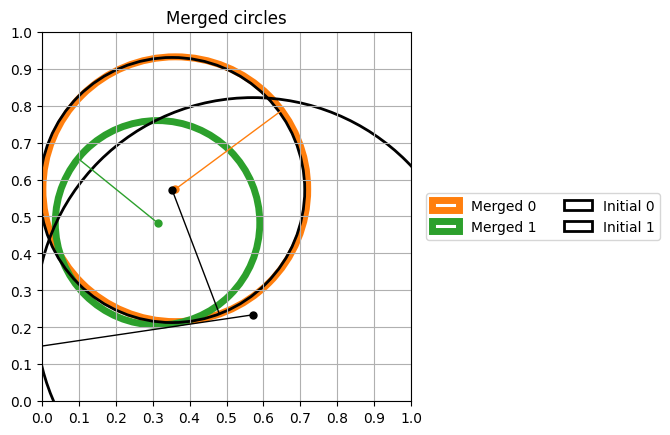

In [35]:
def merge_circles(merged_labels):
    """
    Merges circles based on the provided merged_labels.

    Args:
        merged_labels: A list of sublists, where each sublist contains the indices of circles to be merged.

    Returns:
        A list of merged circles.
    """
    global cluster_dict

    merged_circles = []
    merged_errors = []

    for labels in merged_labels:
        num_labels = len(labels)

        # Extract circles to merge
        circles = [cluster_dict[i]['circle'] for i in labels]
        errors  = [cluster_dict[i]['errors'] for i in labels]

        print_circles(circles, errors, title=f"Merging circles {labels}",
                      label='  Original circle ', enum=True)

        # Calculate the average of the circles to merge
        new_circle = np.mean(circles, axis=0)
        new_errors = np.max(errors, axis=0)

        print_circle(new_circle, new_errors, label="      Merged circle")

        print("      Compatibility:", end='')
        for circle, errors in zip(circles, errors):
            is_compatible = compatible_circles(new_circle, circle, new_errors, errors)
            print(f" {is_compatible}", end='')
        print('\n')

        merged_circles.append(new_circle)
        merged_errors.append(new_errors)

    return merged_circles, merged_errors

#======================= Example usage ========================================#
merged_circles, merged_errors = merge_circles(merged_labels)

print_circles(merged_circles, merged_errors, title="Merged circles:", label='Merged ', enum=True)
plot_circles(merged_circles, title="Merged circles", linewidth=5, label="Merged ", enum=True, plot=False)
plot_circles(initial_circles, label="Initial ", enum=True, color='black', legend=True)

Merging circles [0]
  Original circle : Center = (0.3614 ± 0.0025, 0.5737 ± 0.0026), Radius  = 0.3582 ± 0.0021
  Weights: [395]
     Merged circle: Center = (0.3614 ± 0.0025, 0.5737 ± 0.0026), Radius  = 0.3582 ± 0.0021
     Compatibility: True

Merging circles [4]
  Original circle : Center = (0.3134 ± 0.0045, 0.4828 ± 0.0055), Radius  = 0.2766 ± 0.0051
  Weights: [172]
     Merged circle: Center = (0.3134 ± 0.0045, 0.4828 ± 0.0055), Radius  = 0.2766 ± 0.0051
     Compatibility: True


Weighted Merged circles:
Merged 0: Center = (0.3614, 0.5737), Radius  = 0.3582
Merged 1: Center = (0.3134, 0.4828), Radius  = 0.2766


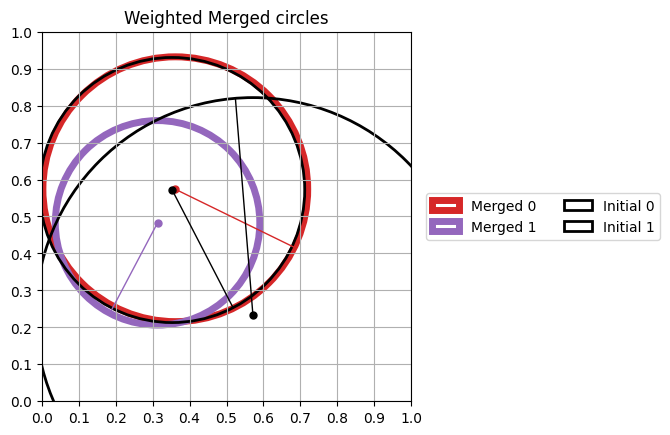

In [36]:
def weighted_merge_circles(merged_labels):
    """
    Unisce i cerchi in base alle etichette fornite in merged_labels,
    effettuando una media pesata con il numero di punti appartenenti
    al cluster di ciascuna label, utilizzando un approccio vettoriale.

    Args:
        merged_labels: Una lista di sottoliste, in cui ogni sottolista
            contiene le etichette dei cerchi da unire.
        filtered_circles: Una lista dei cerchi da unire.
        cluster_card: Un dizionario che mappa le etichette dei cluster
            alle loro cardinalità (numero di punti).

    Returns:
        Una lista di cerchi uniti.
    """
    global cluster_dict

    # Initialize lists to store merged results
    merged_circles = []
    merged_errors  = []

    for labels in merged_labels:
        num_labels = len(labels)

        # Estrai i cerchi e gli errori
        circles = [cluster_dict[i]['circle'] for i in labels]
        errors  = [cluster_dict[i]['errors'] for i in labels]

        print_circles(circles, errors, title=f"Merging circles {labels}",
                      label='  Original circle ', enum=num_labels > 1)

        #if len(labels) == 1:
        #    merged_circles.append(circles[0])
        #    continue

        # Calcola i pesi in base alle cardinalità dei cluster
        weights = np.array([cluster_dict[i]['size'] for i in labels])
        print(f"  Weights: {weights}")

        # Calcola la media pesata delle coordinate dei centri e dei raggi
        new_circle = np.average(circles, axis=0, weights=weights)
        new_errors = np.max(errors, axis=0)

        print_circle(new_circle, new_errors, label="     Merged circle")
        print("     Compatibility:", end='')
        for circle, errors in zip(circles, errors):
            is_compatible = compatible_circles(new_circle, circle, new_errors, errors)
            print(f" {is_compatible}", end='')
        print('\n')

        merged_circles.append(new_circle.tolist())  # Converti in lista
        merged_errors.append(new_errors.tolist())  # Converti in lista

    return merged_circles, merged_errors

#======================= Example usage ========================================#
# Get the list of merged circles
merged_circles, merged_errors = weighted_merge_circles(merged_labels)

print()
print_circles(merged_circles, title="Weighted Merged circles:", label='Merged ', enum=True)
plot_circles(merged_circles, title="Weighted Merged circles", linewidth=5, label="Merged ", enum=True, plot=False)
plot_circles(initial_circles, label="Initial ", enum=True, color='black', legend=True)

##Refine circles

Refining cluster [0]
Merged circle: Center = (0.3614, 0.5737), Radius  = 0.3582
  Single cluster [0]
Center = (0.3614, 0.5737), Radius  = 0.3582
  Refined cluster [0]: Center = (0.3614 ± 0.0025, 0.5737 ± 0.0026), Radius  = 0.3582 ± 0.0021
  Refined circle  [0]: Center = (0.3614 ± 0.0025, 0.5737 ± 0.0026), Radius  = 0.3582 ± 0.0021
  Nearest true circle: Center = (0.3530 ± 0.0000, 0.5716 ± 0.0000), Radius  = 0.3586 ± 0.0000

Refining cluster [4]
Merged circle: Center = (0.3134, 0.4828), Radius  = 0.2766
  Single cluster [4]
Center = (0.3134, 0.4828), Radius  = 0.2766
  Refined cluster [4]: Center = (0.3134 ± 0.0045, 0.4828 ± 0.0055), Radius  = 0.2766 ± 0.0051
  Refined circle  [4]: Center = (0.3134 ± 0.0045, 0.4828 ± 0.0055), Radius  = 0.2766 ± 0.0051
  Nearest true circle: Center = (0.3530 ± 0.0000, 0.5716 ± 0.0000), Radius  = 0.3586 ± 0.0000




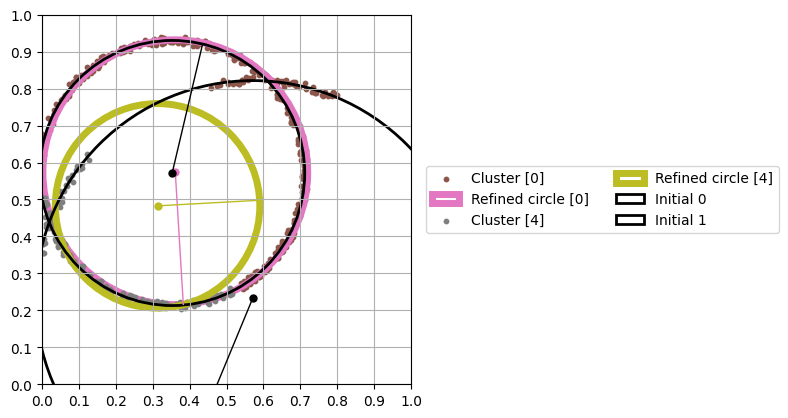

In [37]:
def local_refine_merged_circle(merged_circle, merged_errors, merged_labels):
    """
    Refines the merged circle by fitting a new circle to the combined points of the merged clusters.

    Args:
        merged_circle: the actual merged circle.
        merged_labels: A list of lists, where each sublist contains the labels of clusters to be merged.

    Returns:
        The refined circles.
    """

    print_circle(merged_circle, title=f"Refining cluster {merged_labels}", label=f"Merged circle")

    if len(merged_labels) == 1:
        label = merged_labels[0]
        print_circle(merged_circle, title=f"  Single cluster {merged_labels}")
        print_circle(merged_circle, merged_errors,
                label=f"  Refined cluster {merged_labels}")
        plot_points(cluster_dict[label]['points'], label=f"Cluster {merged_labels}", bound=True, plot=False)

        return True, merged_circle, merged_errors, None

    # Combine points from all clusters in the current merge group
    all_points = []
    for label in merged_labels:
        print_circle(cluster_dict[label]['circle'], cluster_dict[label]['errors'],
                     label=f"  Member {label} - RMSE = {cluster_dict[label]['rmse']:.4f}")
        plot_points(cluster_dict[label]['points'], label=f"Cluster {merged_labels}", bound=True, plot=False)
        all_points.extend(cluster_dict[label]['points'])
    all_points = np.array(all_points)

    # Fit a new circle to the combined points
    if len(all_points) < MIN_SAMPLES:  # Check if enough points exist
        print(f"  Warning: Not enough points to fit a circle for merged clusters {merged_labels}.")
        return False, merged_circle, merged_errors, None

    fit_results = fit_circle_to_points(all_points)
    if fit_results is None:
        print(f"  Warning: Circle fitting failed for merged cluster points {merged_labels}.")
        return False, merged_circle, merged_errors, None

    refined_circle, refined_errors, refined_rmse = fit_results
    print_circle(refined_circle, refined_errors,
                label=f"  Refined circle  {merged_labels} - RMSE = {refined_rmse:.4f}")

    valid, reason = is_a_good_circle(refined_circle, refined_errors, refined_rmse)
    print(f"  Validid circle: {valid} - {reason}")
    if not valid:
        print(f"  Warning: Circle {refined_circle} is not a good circle - {reason}")
        return False, merged_circle, merged_errors, None

    print("  Compatibile:", end='')
    for label in merged_labels:
        circle = cluster_dict[label]['circle']
        errors = cluster_dict[label]['errors']
        is_compatible = compatible_circles(refined_circle, circle, refined_errors, errors)
        print(f" {is_compatible}", end='')
    print()

    return True, refined_circle, refined_errors, refined_rmse

#======================= Example usage ========================================#
for circle, errors, labels in zip(merged_circles, merged_errors, merged_labels):

    refined_ok, refined_circle, refined_errors, refined_rmse = \
        local_refine_merged_circle(circle, errors, labels)

    if refined_ok:
        #cluster_dict[merged_labels[0]]['circle'] = refined_circle
        #cluster_dict[merged_labels[0]]['errors'] = refined_errors
        #cluster_dict[merged_labels[0]]['rmse'] = refined_rmse
        label = f"  Refined circle  {labels}"
        label += f"- RMSE = {refined_rmse:.4f}" if refined_rmse else ""
        print_circle(refined_circle, refined_errors,
                     label=label)
        nearest_circle, _ = find_nearest_circle(initial_circles, refined_circle)
        print_circle(nearest_circle, errors=[0, 0, 0], label=f"  Nearest true circle")
        print()
        plot_circle(refined_circle, label=f"Refined circle {labels}",
                color=get_color(), linewidth=5, plot=False)
print()
#print_circles(initial_circles, title="Initial Circles", label='Initial ', enum=True)
#print_circles(refined_circles, title="Refined Merged Circles", label='Refined ', enum=True)

#plot_circles(refined_circles, title="Refined Merged Circles", linewidth=5, label="Refined ", enum=True, plot=False)
plot_circles(initial_circles, label="Initial ", enum=True, color='black', legend=True)

###Globally refine cluster

Circle -1 is ivalid. Skipping refinement.

Processing circle 0 - RMSE = 0.0279: Center = (0.3614 ± 0.0025, 0.5737 ± 0.0026), Radius  = 0.3582 ± 0.0021
  Number of points in original cluster: 395
  Number of points used for refinement: 365
  Valid circle: True - Valid circle
  Compatible with original: True
   Refined circle 0 - RMSE = 0.0045: Center = (0.3579 ± 0.0004, 0.5730 ± 0.0003), Radius  = 0.3584 ± 0.0002
            Nearest original circle: Center = (0.3530 ± 0.0000, 0.5716 ± 0.0000), Radius  = 0.3586 ± 0.0000

Circle  1 is ivalid. Skipping refinement.
Circle  2 is ivalid. Skipping refinement.
Circle  3 is ivalid. Skipping refinement.

Processing circle 4 - RMSE = 0.0207: Center = (0.3134 ± 0.0045, 0.4828 ± 0.0055), Radius  = 0.2766 ± 0.0051
  Number of points in original cluster: 172
  Number of points used for refinement: 69
  Valid circle: True - Valid circle
  Compatible with original: True
   Refined circle 4 - RMSE = 0.0055: Center = (0.3143 ± 0.0014, 0.4834 ± 0.0013), Ra

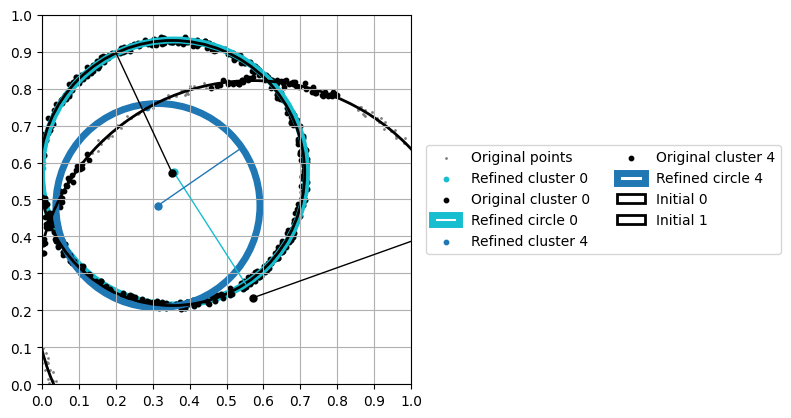

In [38]:
def global_refine_circle(circle, errors, rmse, data_points):
    """
    Refines a circle by fitting a new circle to a subset of data points
    that are close to the original circle.

    Args:
        circle: The original circle to refine.
        errors: Errors associated with the original circle.
        rmse: RMSE of the original circle fit.
        data_points: All data points.

    Returns:
        A tuple containing:
            - True if refinement was successful, False otherwise.
            - The refined circle (or the original if refinement failed).
            - Errors associated with the refined circle.
            - RMSE of the refined circle fit.
            - A mask indicating which data points were used for refinement.
    """

    #print_circle(circle, errors, title="Refining circle",
    #             label=f"Original circle - RMSE ={rmse:.4f}")

    # Calculate distances of all points to the circle's center
    distances = np.sqrt((data_points[:, 0] - circle[0]) ** 2 + (data_points[:, 1] - circle[1]) ** 2)

    # Create a mask to select points within a certain radius of the circle
    #mask = np.abs(distances - circle[2]) <= 3 * rmse  # Using 3 * rmse as a threshold
    mask = np.abs(distances - circle[2]) <= 1 * RADIUS_SCATTER  # Using 3 * RADIUS_SCATTER as a threshold

    # Select the points to use for refinement
    selected_points = data_points[mask]
    num_points = len(selected_points)
    print(f"  Number of points used for refinement: {num_points}")

    # Check if enough points exist for refinement
    if len(selected_points) < MIN_SAMPLES:
        print("  Warning: Not enough points for refinement.")
        return False, circle, errors, rmse, mask  # Return original circle

    # Fit a new circle to the selected points
    fit_results = fit_circle_to_points(selected_points)

    if fit_results is None:
        print("  Warning: Circle fitting failed.")
        return False, circle, errors, rmse, mask  # Return original circle

    refined_circle, refined_errors, refined_rmse = fit_results

    # Validation checks
    valid, reason = is_a_good_circle(refined_circle, refined_errors, refined_rmse)
    print(f"  Valid circle: {valid} - {reason}")

    if not valid:
        print(f"  Warning: Refined circle is not a good circle - {reason}")
        return False, circle, errors, rmse, mask  # Return original circle

    is_compatible = compatible_circles(refined_circle, circle, refined_errors, errors)
    print(f"  Compatible with original: {is_compatible}")

    if not is_compatible:
        print("  Warning: Refined circle is not compatible with the original.")
        return False, circle, errors, rmse, mask  # Return original circle

    #print_circle(refined_circle, refined_errors,
    #             label=f"Refined circle - RMSE ={refined_rmse:.4f}")

    return True, refined_circle, refined_errors, refined_rmse, mask

#======================= Example usage ========================================#
plot_points(data_points, label="Original points", pointsize=1, color='gray', bound=True, plot=False)

for label, circle_dict in cluster_dict.items():
    points = circle_dict['points']
    circle = circle_dict['circle']
    errors = circle_dict['errors']
    rmse = circle_dict['rmse']
    valid = circle_dict['valid']
    num_points = len(points)

    if label == -1 or not valid:
        print(f"Circle {label:2d} is ivalid. Skipping refinement.")
        continue
    #else:
    #    print(f"\nCircle {label} is valid. Refining...")

    print_circle(circle, errors, label=f"\nProcessing circle {label} - RMSE = {rmse:.4f}")
    print(f"  Number of points in original cluster: {num_points}")

    refined_ok, refined_circle, refined_errors, refined_rmse, mask = \
        global_refine_circle(circle, errors, rmse, data_points)

    if refined_ok:
        # Use the refined circle
        #print("  Circle refined successfully!")
        print_circle(refined_circle, refined_errors,
                     label=f"   Refined circle {label} - RMSE = {refined_rmse:.4f}")
        nearest_circle, _ = find_nearest_circle(initial_circles, refined_circle)
        print_circle(nearest_circle, errors=[0, 0, 0], label=f"            Nearest original circle")

        color = get_color()
        plot_points(data_points[mask], label=f"Refined cluster {label}", color=color, bound=True, plot=False)
        plot_points(points, label=f"Original cluster {label}", color='black', bound=True, plot=False)
        plot_circle(refined_circle, label=f"Refined circle {label}",
                color=color, linewidth=5, plot=False)
    else:
        # Refinement failed, use the original circle
        print("Circle refinement failed.")

    print()

plot_circles(initial_circles, label="Initial ", enum=True, color='black', legend=True, plot=False)
#plot_circles(refined_circles, title="Refined Merged Circles", linewidth=5, label="Refined ", enum=True, plot=False
plt.show()